# EDA and Time Series Model Fitting
---
This notebook is concerned with exploring a few representative grids of the ERA5 dataset (places with constant low wind speeds and constant high speeds). The ACF, PACF, and stationarity are checked as well. The models used are Naive, Windowed, Exponential Moving Average, ARIMA, Prophet, and LSTM.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_pickle("results/era0820_100m.pkl")
df["date"] = pd.to_datetime(df["date"])
df

,date,lat,lon,windvelo
0,2008-01-01,21.50,116.5,11.287799
1,2008-01-01,21.25,116.5,11.269390
2,2008-01-01,21.00,116.5,11.237897
3,2008-01-01,20.75,116.5,11.260742
4,2008-01-01,20.50,116.5,11.333221
...,...,...,...,...
498415,2020-12-01,5.00,127.5,1.671269
498416,2020-12-01,4.75,127.5,1.614607
498417,2020-12-01,4.50,127.5,1.562249
498418,2020-12-01,4.25,127.5,1.502779


In [3]:
# Somewhere in Antique
maxv_df = df[(df.lon == 122.0) \
             & (df.lat == 11.75)] \
            .set_index("date", drop=True) \
            .drop(columns=["lat", "lon"])
maxv_df

,windvelo
date,
2008-01-01,9.513057
2008-02-01,10.080398
2008-03-01,8.008327
2008-04-01,7.624721
2008-05-01,4.655556
...,...
2020-08-01,3.281062
2020-09-01,1.326175
2020-10-01,1.824418


In [4]:
# Somewhere in Davao
minv_df = df[(df.lon == 124.75) \
             & (df.lat == 6.75)] \
            .set_index("date", drop=True) \
            .drop(columns=["lat", "lon"])
minv_df

,windvelo
date,
2008-01-01,0.193310
2008-02-01,0.279057
2008-03-01,0.435242
2008-04-01,0.377758
2008-05-01,0.338360
...,...
2020-08-01,0.110444
2020-09-01,0.168118
2020-10-01,0.415854


In [5]:
def convert_to_dict(lst):
    res_dct = {i+1: lst[i] for i in range(0, len(lst))}
    return res_dct

In [6]:
def get_acf_lag(df, nlags=12):
    acf = sm.tsa.acf(df, nlags=nlags, alpha=0.05, qstat=True, fft=False)

    confidence_intervals = acf[1]
    p_values = convert_to_dict(acf[3])

    lag = min(p_values, key=p_values.get)
    p_value = p_values[lag]
    acf = np.mean(confidence_intervals[lag-1])

    return { "lag": int(lag), "acf": acf, "p_value": p_value }

In [7]:
def test_stationarity(timeseries, window=12, cutoff=0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=20)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [8]:
def plot_autocorrelations(df, lags=12):
    acf_info = get_acf_lag(df, nlags=lags)
    print("Lag: %d, ACF: %.08f, p-value:" % (acf_info["lag"], acf_info["acf"]))
    print(acf_info["p_value"])

    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    plt.plot(df)

    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    acf = plot_acf(df, lags=lags, ax=ax1)
    pacf = plot_pacf(df, lags=lags, ax=ax2)
    
    test_stationarity(df)

Lag: 36, ACF: 0.04046662, p-value:
1.8638168267255062e-23


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


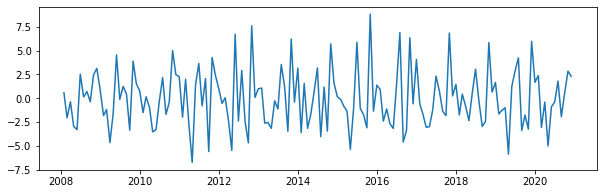

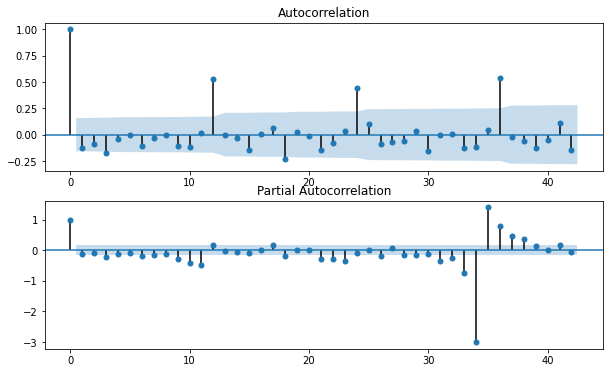

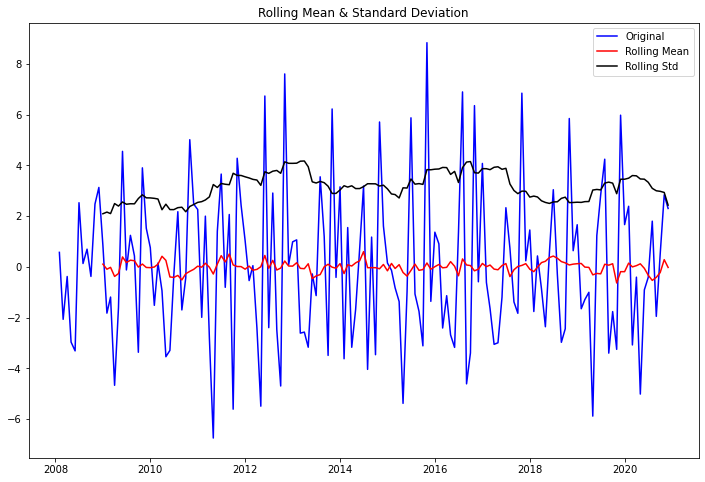

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.244033e+00
p-value                        1.852256e-10
#Lags Used                     1.100000e+01
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64


In [9]:
plot_autocorrelations(maxv_df["windvelo"].interpolate().diff()[1:], 42)

Lag: 36, ACF: -0.06863176, p-value:
1.2236829588580213e-06


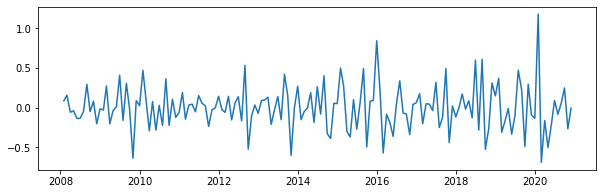

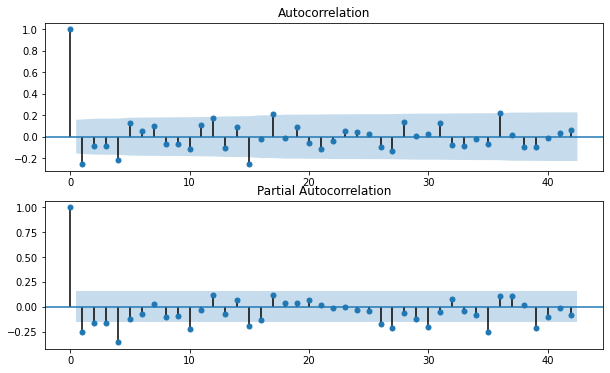

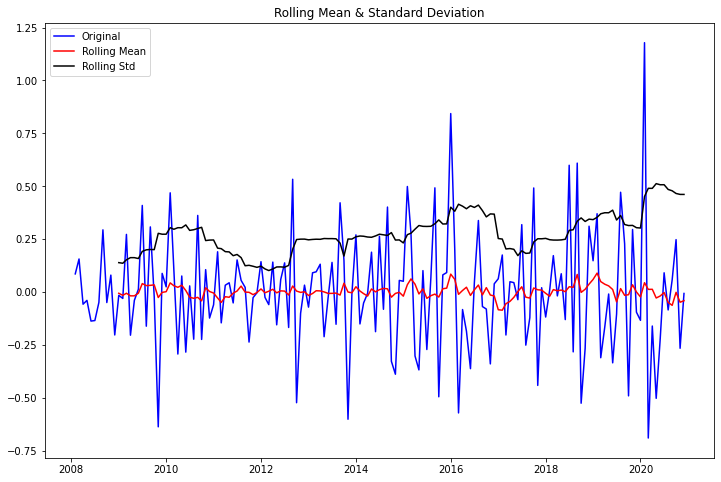

Results of Dickey-Fuller Test:
p-value = 0.0034. The series is likely stationary.
Test Statistic                  -3.755967
p-value                          0.003391
#Lags Used                      16.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


In [10]:
plot_autocorrelations(minv_df["windvelo"].interpolate().diff()[1:], 42)

## Methods to run to verify validity of time series model

In [11]:
def plot_original(train_df, test_df, feature="windvelo"):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    train_df[feature].plot(color="C7", ax=ax, label="train")
    test_df[feature].plot(color="C0", ax=ax, label="test")

    plt.legend()
    plt.ylabel("wind speed at a sector")

In [12]:
def get_naive_forecast(df, start_date):
    return df.shift(1)[start_date:]

In [13]:
def get_windowed_forecast(df, start_date, roll_value=12):
    return df.rolling(roll_value).mean().shift(1)[start_date:]

In [14]:
def get_ema_forecast(df, start_date, alpha=0.7):
    # alpha = 1 is similar to naive
    return df.ewm(alpha=alpha).mean().shift(1)[start_date:]

In [15]:
def get_arima_fit(train_df, feature, order):
    model = ARIMA(endog=train_df[feature], order=order)  
    return model.fit()

In [16]:
def get_arima_forecast(model_fit, test_count, feature):
    return pd.DataFrame(model_fit.forecast(test_count, dynamic=True))\
                .rename(columns={"predicted_mean": feature})

In [17]:
# Prophet accepts a certain column signature
def serialize_prophet(df, feature):
    df = df.reset_index()
    fb_df = pd.DataFrame(columns=["ds", "y"])
    fb_df["ds"] = pd.to_datetime(df["date"])
    fb_df["y"] = df[feature]
    return fb_df

In [18]:
def get_prophet_forecast(train_df, test_df):
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(train_df)
    forecast = model.predict(test_df)
#     print(forecast.columns)
#     model.plot(forecast)
#     model.plot_components(forecast)
    return forecast

In [19]:
# The fb_feature we will use is yhat. Other features exist such as yhat_lower and yhat_upper.
def unserialize_prophet(df, fb_feature, feature):
    df = df.rename(columns={"ds": "date", fb_feature: feature}).set_index("date", drop=True)
    return df[[feature]]

In [20]:
# LSTM model accepts a dataset matrix
# This method produces 2 matrices X and Y
# where Y value at time t is the X value at time t + look back value
def prepare_for_lstm(df, look_back=1):
    X, Y = [], []
    for i in range(len(df)-look_back):
        X.append(df[i:(i+1)])
        Y.append(df[(i+look_back):(i+look_back+1)])
    return np.array(X), np.array(Y)

In [21]:
# LSTM model outputs a dataset matrix as well
# This method unpacks the forecast matrix using the test data as pattern
# This method also accepts a scaler to inverse the action during preparation
def unpack_forecast_matrix(lstm_matrix, test_df_pattern, scaler=None):
    forecast_len = len(lstm_matrix)
    forecast_df = test_df_pattern.iloc[:forecast_len]
    raw_forecast = []
    for i in range(forecast_len):
        raw_forecast.append(lstm_matrix[i][0])
    if scaler != None:
        raw_forecast = scaler.inverse_transform(raw_forecast)
    forecast_df.iloc[:, 1] = raw_forecast
    return forecast_df

In [22]:
def get_lstm_forecast(train_df, test_df, feature="windvelo", \
                      time_step=1, lstm_units=50, activation="relu", \
                      dense_units=1, epochs=100, verbose=0):
    trainX, trainY = prepare_for_lstm(train_df[[feature]], look_back=time_step)

    # Since testY won't be used in this version of LSTM sequence,
    # we refrained from setting a look back value to prevent the trimming of the testX length
    testX, testY = prepare_for_lstm(test_df[[feature]], look_back=0)

    # reshape input to be [sample count, time steps, feature count]
    trainX = np.reshape(trainX, (trainX.shape[0], time_step, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], time_step, testX.shape[1]))

    model = Sequential()
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True, \
                   input_shape=(testX.shape[1], testX.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=dense_units))
    model.compile(optimizer="adam", loss="mse")
    
    model.fit(trainX, trainY, epochs=epochs, verbose=verbose)

    # make predictions
    # trainPredict = model.predict(trainX)
    return model.predict(testX)

In [23]:
def plot_forecast(train_df, test_df, forecast_df, feature):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    train_df[feature].plot(color="C7", ax=ax, label="train")
    test_df[feature].plot(color="C0", ax=ax, label="test")

    forecast_df[feature].plot(color="C1", ax=ax, label="forecast")

    plt.legend()
    plt.ylabel("wind velocity at a sector")

    print("The RMSE is %0.4f" % rmse(test_df[feature], forecast_df[feature]))
    print("The MAE is %0.4f" % meanabs(test_df[feature], forecast_df[feature]))
    print("The R2 score is %0.4f" % r2_score(test_df[feature], forecast_df[feature]))

In [24]:
maxv_train_df = maxv_df["2008-01-01":"2017-12-01"]
maxv_test_df = maxv_df["2018-01-01":]
minv_train_df = minv_df["2008-01-01":"2017-12-01"]
minv_test_df = minv_df["2018-01-01":]

In [25]:
len(maxv_train_df), len(maxv_test_df), len(minv_train_df), len(minv_test_df)

(120, 36, 120, 36)

In [26]:
maxv_diff_df = maxv_df.diff().dropna()
maxdiff_train_df = maxv_diff_df["2008-01-01":"2017-12-01"]
maxdiff_test_df = maxv_diff_df["2018-01-01":]

minv_diff_df = minv_df.diff().dropna()
mindiff_train_df = minv_diff_df["2008-01-01":"2017-12-01"]
mindiff_test_df = minv_diff_df["2018-01-01":]

In [27]:
len(maxdiff_train_df), len(maxdiff_test_df), len(mindiff_train_df), len(mindiff_test_df)

(119, 36, 119, 36)

In [28]:
maxv_head_df = maxv_train_df.tail(1)
minv_head_df = minv_train_df.tail(1)
maxv_head_df, minv_head_df

(            windvelo
 date                
 2017-12-01  8.351656,
             windvelo
 date                
 2017-12-01  0.183423)

In [29]:
test_start_date = "2018-01-01"
months = pd.date_range(start=test_start_date, periods=len(maxv_test_df), freq="MS")
months

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [30]:
def inverse_diff(head_df, diff_df, feature="windvelo"):
    return pd.DataFrame(data=head_df.append(diff_df).cumsum().iloc[1:, 0], index=months)

In [31]:
feature = "windvelo"

## Sector with Higher Average Wind Speeds

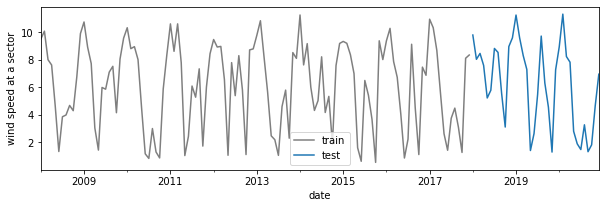

In [32]:
plot_original(maxv_train_df, maxv_test_df, feature)

The RMSE is 2.7374
The MAE is 2.2392
The R2 score is 0.1878


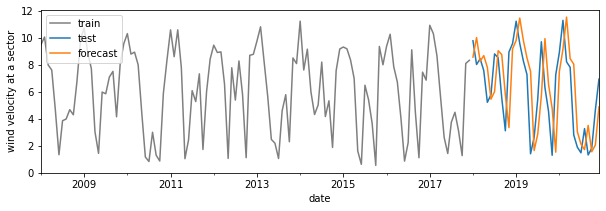

In [33]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_naive_forecast(maxv_diff_df, test_start_date)),
              feature)

The RMSE is 4.2395
The MAE is 3.2249
The R2 score is -0.9482


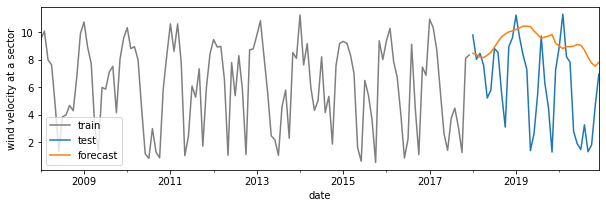

In [34]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_windowed_forecast(maxv_diff_df, test_start_date)),
              feature)

The RMSE is 5.4604
The MAE is 4.5175
The R2 score is -2.2318


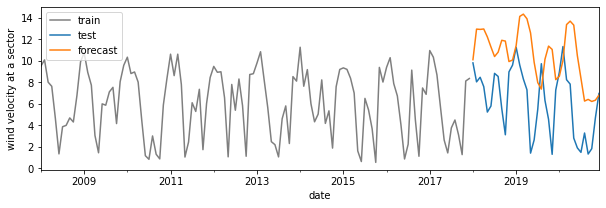

In [35]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_windowed_forecast(maxv_diff_df, test_start_date, 3)),
              feature)

The RMSE is 2.7374
The MAE is 2.2392
The R2 score is 0.1878


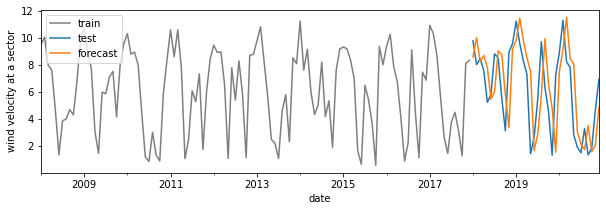

In [36]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=1)),
              feature)

The RMSE is 3.5486
The MAE is 2.9435
The R2 score is -0.3649


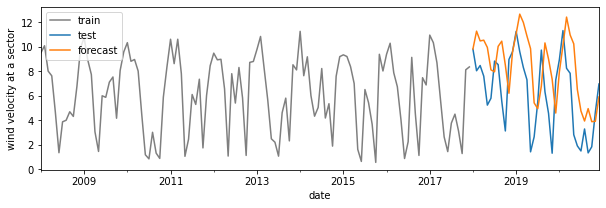

In [37]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=0.7)),
              feature)

The RMSE is 3.9318
The MAE is 3.2061
The R2 score is -0.6756


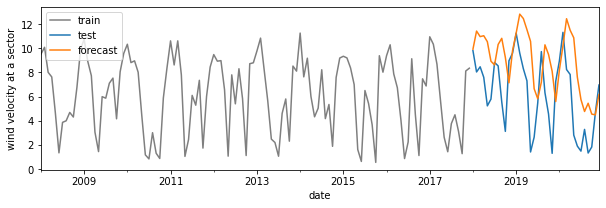

In [38]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=0.6)),
              feature)

The RMSE is 4.3075
The MAE is 3.5019
The R2 score is -1.0112


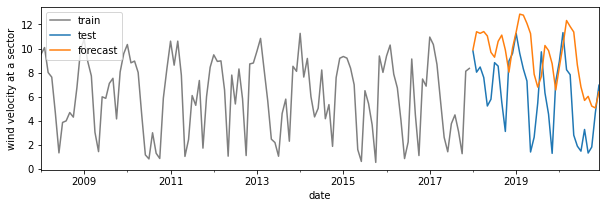

In [39]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=0.5)),
              feature)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: 

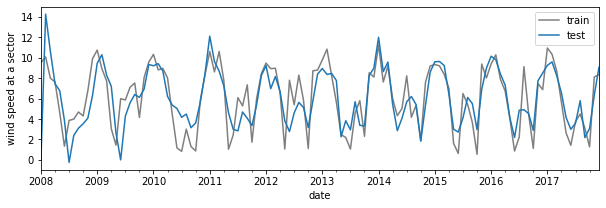

In [40]:
model_fit = get_arima_fit(maxv_train_df, feature, (12, 2, 24))
fitted_df = pd.DataFrame(model_fit.fittedvalues).rename(columns={0: feature})
plot_original(maxv_train_df, fitted_df, feature)

The RMSE is 2.0948
The MAE is 1.6734
The R2 score is 0.5243


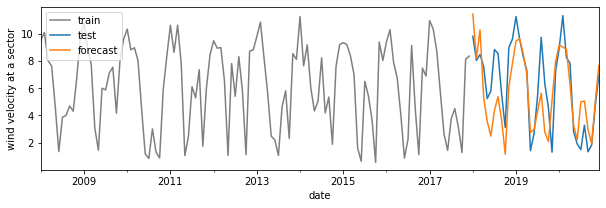

In [41]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              get_arima_forecast(model_fit, len(maxv_test_df), feature),
              feature)

The RMSE is 2.2103
The MAE is 1.7104
The R2 score is 0.4705


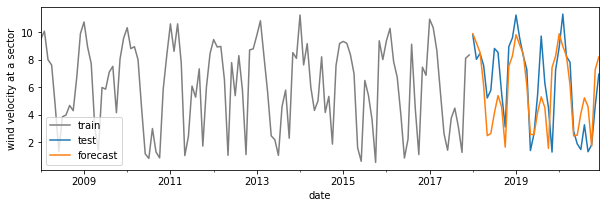

In [42]:
# FB Prophet
plot_forecast(maxv_train_df,
              maxv_test_df,
              unserialize_prophet(
                  get_prophet_forecast(
                      serialize_prophet(maxv_train_df, feature),
                      serialize_prophet(maxv_test_df, feature)),
                  "yhat",
                  feature),
              feature)

The RMSE is 1.5205
The MAE is 1.3259
The R2 score is 0.7494


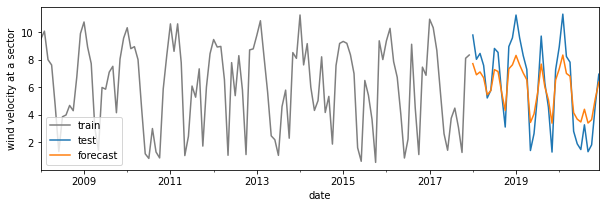

In [43]:
# LSTM RelU activation
ru_train_df = maxv_train_df.reset_index()
ru_test_df = maxv_test_df.reset_index()
ru_train_df = ru_train_df.append(ru_test_df.iloc[0:1]).reset_index(drop=True)
ru_matrix = get_lstm_forecast(ru_train_df, ru_test_df)

plot_forecast(maxv_train_df,
              maxv_test_df,
              unpack_forecast_matrix(ru_matrix, maxv_test_df.reset_index()[["date", feature]]).set_index("date"),
              feature)

The RMSE is 1.6388
The MAE is 1.3813
The R2 score is 0.7089


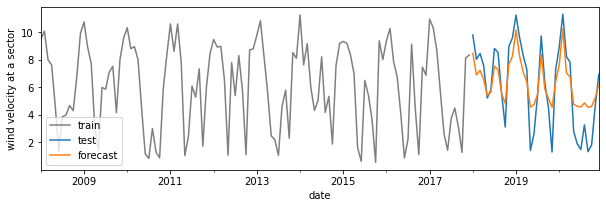

In [44]:
# LSTM TanH activation
scaler = MinMaxScaler(feature_range=(-1, 1))
th_train_df = maxv_train_df.reset_index()
th_test_df = maxv_test_df.reset_index()
th_train_df = th_train_df.append(th_test_df.iloc[0:1]).reset_index(drop=True)
th_train_df[feature] = scaler.fit_transform(th_train_df[[feature]])
th_test_df[feature] = scaler.fit_transform(th_test_df[[feature]])
th_matrix = get_lstm_forecast(th_train_df, th_test_df, activation="tanh")

plot_forecast(maxv_train_df,
              maxv_test_df,
              unpack_forecast_matrix(
                  th_matrix, maxv_test_df.reset_index()[["date", feature]], scaler).set_index("date"),
              feature)

## Sector with Minimum Average Wind Velocity

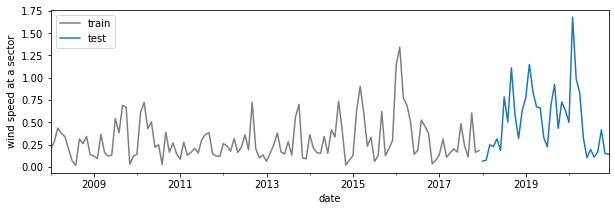

In [45]:
plot_original(minv_train_df, minv_test_df, feature)

The RMSE is 0.3620
The MAE is 0.2760
The R2 score is 0.0038


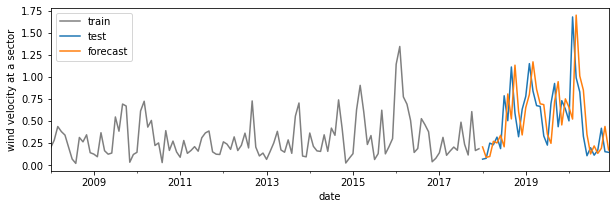

In [46]:
plot_forecast(minv_train_df,
              minv_test_df,
              inverse_diff(minv_head_df, get_naive_forecast(minv_diff_df, test_start_date)),
              feature)

The RMSE is 0.3794
The MAE is 0.2934
The R2 score is -0.0945


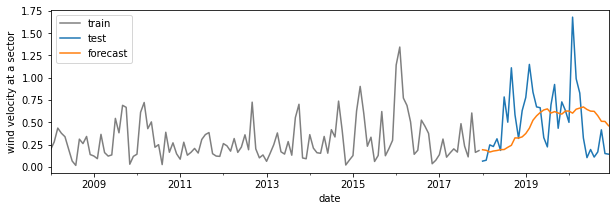

In [47]:
# yearly
plot_forecast(minv_train_df,
              minv_test_df,
              inverse_diff(minv_head_df, get_windowed_forecast(minv_diff_df, test_start_date)),
              feature)

The RMSE is 0.3724
The MAE is 0.2646
The R2 score is -0.0542


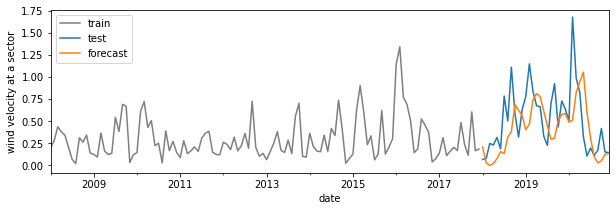

In [49]:
# quarterly
plot_forecast(minv_train_df,
              minv_test_df,
              inverse_diff(minv_head_df, get_windowed_forecast(minv_diff_df, test_start_date, 3)),
              feature)

The RMSE is 0.3620
The MAE is 0.2760
The R2 score is 0.0038


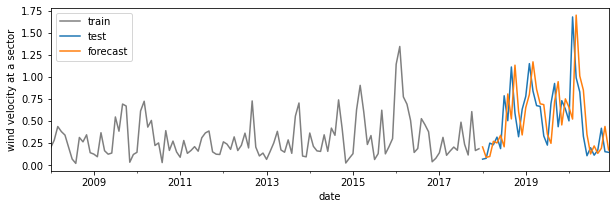

In [50]:
plot_forecast(minv_train_df,
              minv_test_df,
              inverse_diff(minv_head_df, get_ema_forecast(minv_diff_df, test_start_date, alpha=1)),
              feature)

The RMSE is 0.3452
The MAE is 0.2499
The R2 score is 0.0939


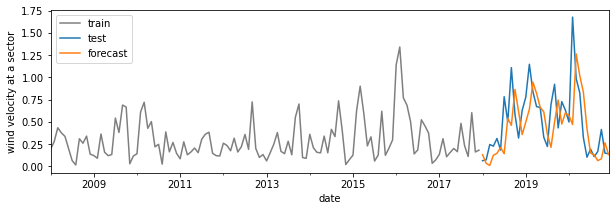

In [51]:
plot_forecast(minv_train_df,
              minv_test_df,
              inverse_diff(minv_head_df, get_ema_forecast(minv_diff_df, test_start_date, alpha=0.7)),
              feature)

The RMSE is 0.3459
The MAE is 0.2434
The R2 score is 0.0903


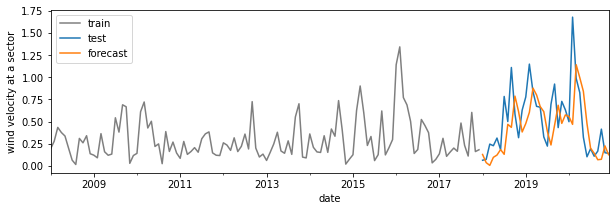

In [52]:
plot_forecast(minv_train_df,
              minv_test_df,
              inverse_diff(minv_head_df, get_ema_forecast(minv_diff_df, test_start_date, alpha=0.6)),
              feature)

The RMSE is 0.3475
The MAE is 0.2423
The R2 score is 0.0817


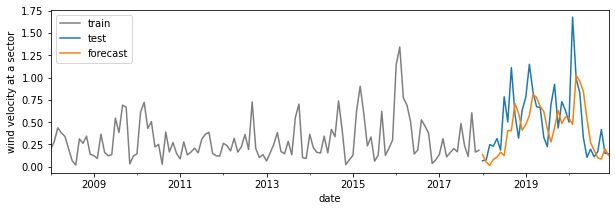

In [53]:
plot_forecast(minv_train_df,
              minv_test_df,
              inverse_diff(minv_head_df, get_ema_forecast(minv_diff_df, test_start_date, alpha=0.5)),
              feature)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum L

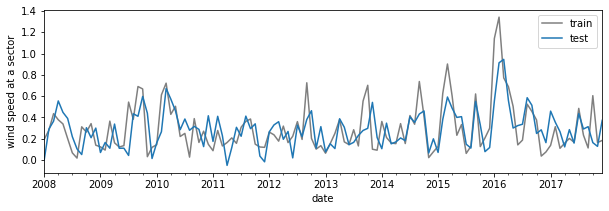

In [54]:
model_fit = get_arima_fit(minv_train_df, feature, (12, 2, 24))
fitted_df = pd.DataFrame(model_fit.fittedvalues).rename(columns={0: feature})
plot_original(minv_train_df, fitted_df, feature)

The RMSE is 0.3998
The MAE is 0.3077
The R2 score is -0.2153


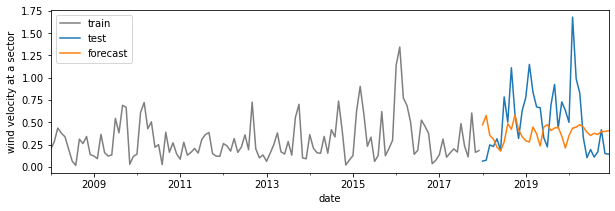

In [55]:
plot_forecast(minv_train_df,
              minv_test_df,
              get_arima_forecast(model_fit, len(minv_test_df), feature),
              feature)

The RMSE is 0.3772
The MAE is 0.2960
The R2 score is -0.0817


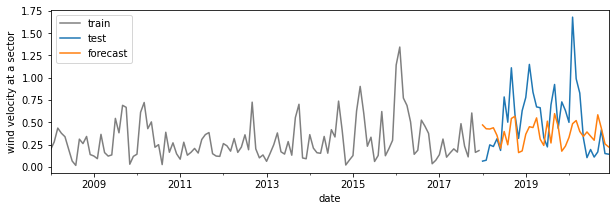

In [56]:
# FB Prophet
plot_forecast(minv_train_df,
              minv_test_df,
              unserialize_prophet(
                  get_prophet_forecast(
                      serialize_prophet(minv_train_df, feature),
                      serialize_prophet(minv_test_df, feature)),
                  "yhat",
                  feature),
              feature)

The RMSE is 0.2366
The MAE is 0.1953
The R2 score is 0.5745


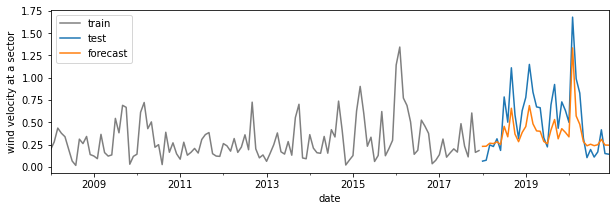

In [57]:
# LSTM RelU activation
ru_train_df = minv_train_df.reset_index()
ru_test_df = minv_test_df.reset_index()
ru_train_df = ru_train_df.append(ru_test_df.iloc[0:1]).reset_index(drop=True)
ru_matrix = get_lstm_forecast(ru_train_df, ru_test_df)

plot_forecast(minv_train_df,
              minv_test_df,
              unpack_forecast_matrix(ru_matrix, minv_test_df.reset_index()[["date", feature]]).set_index("date"),
              feature)

The RMSE is 0.2181
The MAE is 0.1796
The R2 score is 0.6385


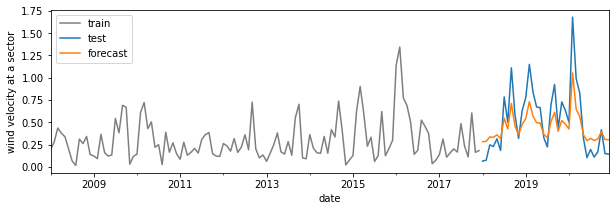

In [58]:
# LSTM TanH activation
scaler = MinMaxScaler(feature_range=(-1, 1))
th_train_df = minv_train_df.reset_index()
th_test_df = minv_test_df.reset_index()
th_train_df = th_train_df.append(th_test_df.iloc[0:1]).reset_index(drop=True)
th_train_df[feature] = scaler.fit_transform(th_train_df[[feature]])
th_test_df[feature] = scaler.fit_transform(th_test_df[[feature]])
th_matrix = get_lstm_forecast(th_train_df, th_test_df, activation="tanh")

plot_forecast(minv_train_df,
              minv_test_df,
              unpack_forecast_matrix(
                  th_matrix, minv_test_df.reset_index()[["date", feature]], scaler).set_index("date"),
              feature)

## RMSE Results
---
|Grid              |Naive |Windowed 12|Windowed 3|EMA 1 |EMA 0.7|EMA 0.6|EMA 0.5|ARIMA |Prophet|LSTM RelU|LSTM TanH|
|:-----------------|------|-----------|----------|------|-------|-------|-------|------|-------|---------|---------|
|Higher Wind Speeds|2.7374|4.2395     |5.4604    |2.7374|3.5486 |3.9318 |4.3075 |2.0948|2.2103 |1.5205   |1.6388   |
|Rank              |5*    |9          |11        |5*    |7      |8      |10     |3     |4      |1        |2        |
|Lower Wind Speeds |0.3620|0.3794     |0.3724    |0.3620|0.3452 |0.3459 |0.3475 |0.3998|0.3772 |0.2366   |0.2181   |
|Rank              |6*    |10         |8         |6*    |3      |4      |5      |11    |9      |2        |1        |

Note: (*) Naive and EMA with alpha 1 are the same.